In [1]:
import my_package.rectification as rectification
import importlib
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import SpatialGlue

In [3]:
import os
# os.chdir("/home/llx/project/MSI_data/sma/V11T17-102/V11T17-102_B1/output_data/V11T17-102_B1_MSI")
omics_adata_1_path="V11T17-102_B1.Visium.FMP.220826_smamsi.csv"
omics_adata_2_path='/home/llx/project/MSI_data/sma/V11T17-102/V11T17-102_B1/output_data/V11T17-102_B1_RNA/outs/'
HE_path="/home/llx/project/MSI_data/sma/V11T17-102/V11T17-102_B1/output_data/V11T17-102_B1_RNA/outs/spatial/tissue_hires_image.png"

In [4]:
import scanpy as sc

In [5]:
ms_adata = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/V11T17-102_B1_MSI/ms.h5ad')

In [6]:
st_adata=sc.read_visium(omics_adata_2_path,
                        count_file='filtered_feature_bc_matrix.h5',
                        source_image_path='tissue_hires_image.png')
st_adata

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4984 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import anndata as ad
st_intensity = csr_matrix(st_adata.X.A, dtype=np.float32)
print(st_intensity.shape)
st_adata1 = ad.AnnData(st_intensity)
st_adata1.var_names=st_adata.var_names
st_adata1.obs_names=st_adata.obs_names
st_adata1.obs["array_row"]=st_adata.obs["array_row"]##raw x
st_adata1.obs["array_col"]=st_adata.obs["array_col"]##raw5 y
st_adata1.obsm["spatial"]=st_adata.obsm["spatial"]*0.04155585
from PIL import Image
image_path = '/home/llx/project/MSI_data/sma/V11L12-109/V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "V11L12-109_B1"  # 你可以自定义这个 ID
st_adata1.uns[spatial_key] = {library_id: {}}
st_adata1.uns[spatial_key][library_id]["images"] = {"hires": image_array}
st_adata1.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

(4984, 17943)


In [8]:
st_adata1.obsm['spatial']

array([[ 419.714085  ,  118.1017257 ],
       [1455.1196436 , 1169.25695145],
       [ 745.2626139 ,  181.64062035],
       ...,
       [ 550.6981242 , 1062.70775205],
       [ 718.54220235, 1650.63991785],
       [ 841.5890742 ,  265.74966075]])

[<Axes: title={'center': '674.28592'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '674.2805'}, xlabel='spatial1', ylabel='spatial2'>]

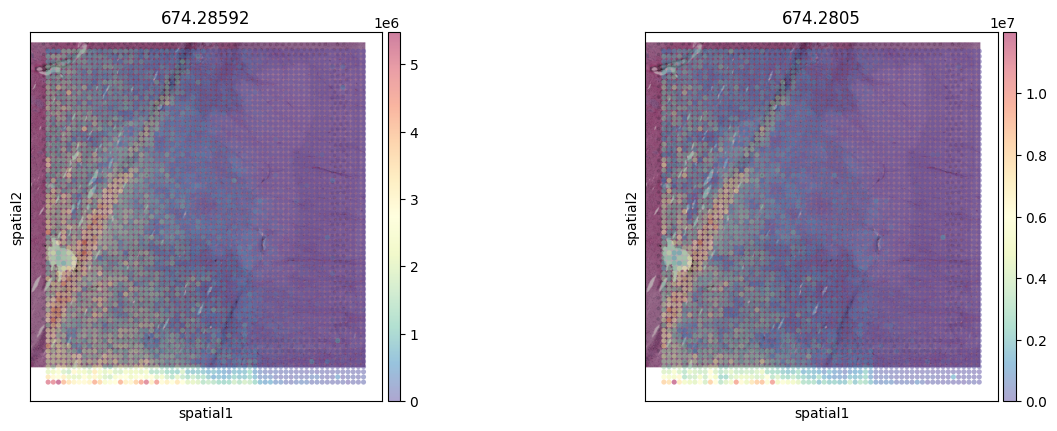

In [9]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['674.28592','674.2805'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=30,
              spot_size=None, 
              bw=False, 
              alpha_img=1,
              alpha=0.5,
              show=False)

In [10]:
sc.pp.normalize_total(ms_adata, target_sum=1e4)
sc.pp.log1p(ms_adata)

[<Axes: title={'center': '674.28592'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '674.2805'}, xlabel='spatial1', ylabel='spatial2'>]

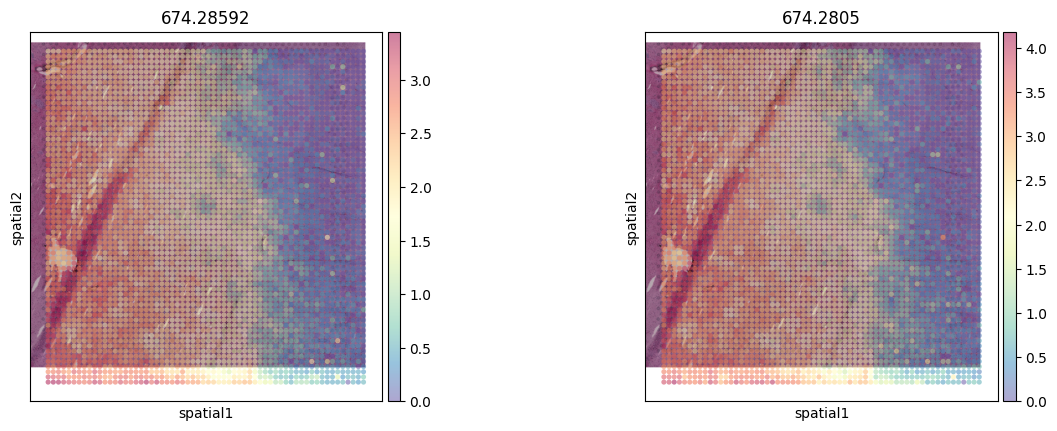

In [11]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['674.28592','674.2805'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=30,
              spot_size=None, 
              bw=False, 
              alpha_img=1,
              alpha=0.5,
              show=False)

In [12]:
ms_adata.obsm['spatial']

array([[ 120.        , 2000.        ],
       [ 150.40000078, 2000.        ],
       [ 180.80000156, 2000.        ],
       ...,
       [1913.60004592,   54.39995019],
       [1944.00004669,   54.39995019],
       [1974.40004747,   54.39995019]])

In [13]:
ms_adata.uns['coord'] = st_adata1.obsm['spatial']

In [14]:
import SM2ST as SMLED
adata_SMLED = SMLED.train_SMLED(adata=ms_adata, mask_ratio=0., coord_sf=2.0, train_epoch=15000, save_reconstrction=True, experiment='generation', WMMSE=1.)

Size of Input:  (4030, 1538)
120.0 54.399950192638926
pixel_step: 48.20485764796378
              0          1
0      1.000000  41.361079
1      1.630642  41.361079
2      2.261284  41.361079
3      2.891926  41.361079
4      3.522567  41.361079
...         ...        ...
4025  36.946586   1.000000
4026  37.577228   1.000000
4027  38.207869   1.000000
4028  38.838511   1.000000
4029  39.469153   1.000000

[4030 rows x 2 columns]               0          1
0      7.217508   2.321480
1     28.696786  24.127482
2     13.970946   3.639582
3      7.922679  28.009373
4     26.722651   8.450782
...         ...        ...
4979  13.677843  27.583512
4980  10.674399  28.449028
4981   9.934745  21.917141
4982  13.416637  34.113675
4983  15.969219   5.384407

[4984 rows x 2 columns]


Epochs: 100%|██████████| 15000/15000 [2:53:45<00:00,  1.44it/s, loss_re: 0.05191, loss_lat: 0.32321, loss_GA: 0.00027, loss: 0.14914, loss_DA: 1.38584] 


In [15]:
from PIL import Image
image_path = '/home/llx/project/MSI_data/sma/V11T17-102/V11T17-102_B1/output_data/V11T17-102_B1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "tV11L12-038_A1_c"  # 你可以自定义这个 ID
adata_SMLED.uns[spatial_key] = {library_id: {}}
adata_SMLED.uns[spatial_key][library_id]["images"] = {"hires": image_array}
adata_SMLED.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

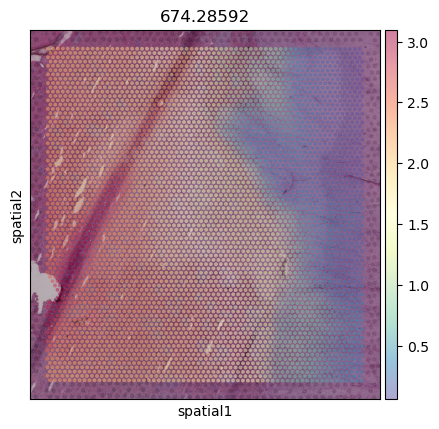

In [16]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['674.28592'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

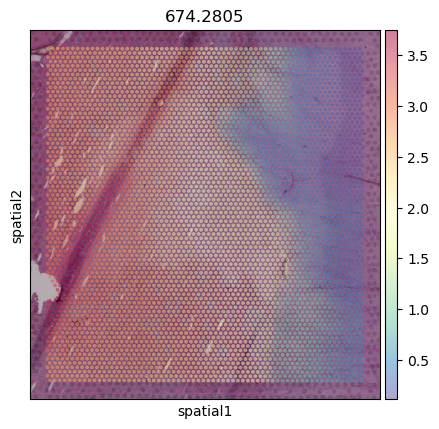

In [17]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['674.2805'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

In [18]:
adata_SMLED.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_V11T17-102_B1.h5ad')

In [14]:
adata_omics2 = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_V11T17-102_B1.h5ad')

In [15]:
st_adata.var

gene_ids    feature_types  genome
SAMD11   ENSG00000187634  Gene Expression  GRCh38
NOC2L    ENSG00000188976  Gene Expression  GRCh38
KLHL17   ENSG00000187961  Gene Expression  GRCh38
PLEKHN1  ENSG00000187583  Gene Expression  GRCh38
PERM1    ENSG00000187642  Gene Expression  GRCh38
...                  ...              ...     ...
TSPY1    ENSG00000258992  Gene Expression  GRCh38
USP9Y    ENSG00000114374  Gene Expression  GRCh38
DDX3Y    ENSG00000067048  Gene Expression  GRCh38
TMSB4Y   ENSG00000154620  Gene Expression  GRCh38
KDM5D    ENSG00000012817  Gene Expression  GRCh38

[17943 rows x 3 columns]

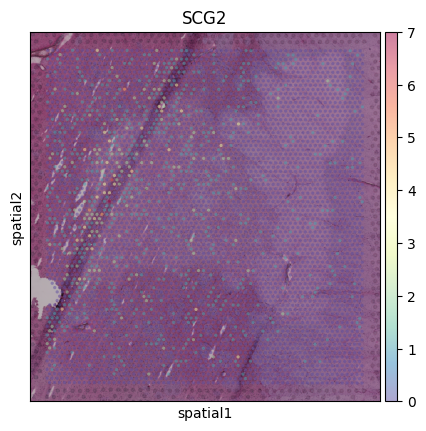

In [16]:
sc.pl.spatial(st_adata, 
              img_key="hires", 
              color=['SCG2'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1,
            alpha=0.5)#color是一个感兴趣的基因的list

In [17]:
# Specify data type
data_type = '10x'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [18]:
adata_omics1 = st_adata
adata_omics2 = adata_omics2

In [19]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

sc.pp.filter_genes(adata_omics1, min_cells=3)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=500) #
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics1_high.n_vars-1)

# MASS
sc.pp.filter_genes(adata_omics2, min_cells=3)
sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=500) #
# sc.pp.normalize_total(adata_omics2, target_sum=1e4)
# sc.pp.log1p(adata_omics2)
# adata_omics2 = STMGraph_OM2.clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2_high =  adata_omics2[:, adata_omics2.var['highly_variable']]
adata_omics2.obsm['feat'] = pca(adata_omics2_high, n_comps=adata_omics2_high.n_vars-1)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [20]:
from SpatialGlue.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [21]:
# define model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type, device=device)

# train model
output = model.train()

  0%|          | 0/200 [00:00<?, ?it/s]/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/llx/project/jupyternotebook/1_pyg_backup/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 200/200 [00:04<00:00, 42.05it/s]

Model training finished!



In [22]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

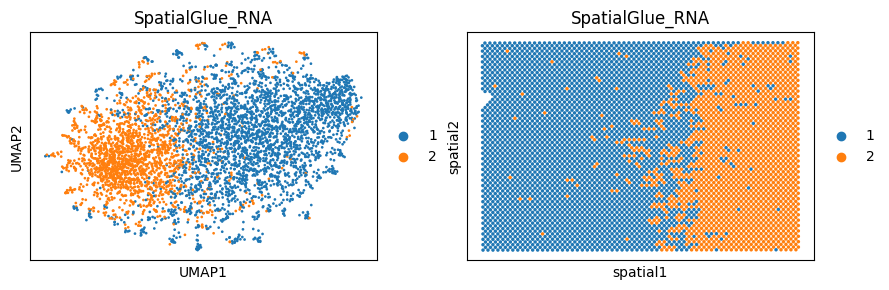

In [24]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
import rpy2
os.environ['R_HOME'] = '/home/llx/software/miniconda3/envs/pyg_ms/lib/R'
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='emb_latent_omics1', add_key='SpatialGlue_RNA', n_clusters=2, method=tool, use_pca=False)
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='emb_latent_omics1', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue_RNA', ax=ax_list[0], title='SpatialGlue_RNA', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_RNA', ax=ax_list[1], title='SpatialGlue_RNA', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


[<Axes: title={'center': 'SpatialGlue_RNA'}, xlabel='spatial1', ylabel='spatial2'>]

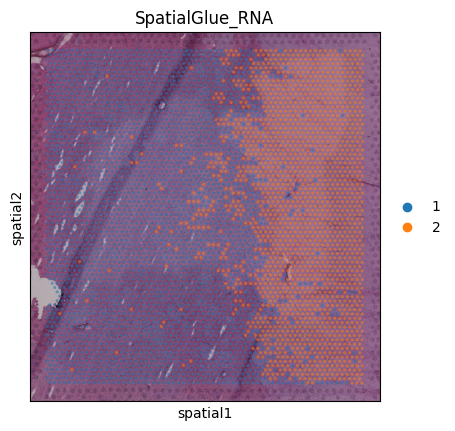

In [33]:
sc.pl.spatial(adata, 
              img_key="hires", 
              color=['SpatialGlue_RNA'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None, 
              bw=False, 
              alpha_img=1,
              alpha=0.5,
              show=False)

fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

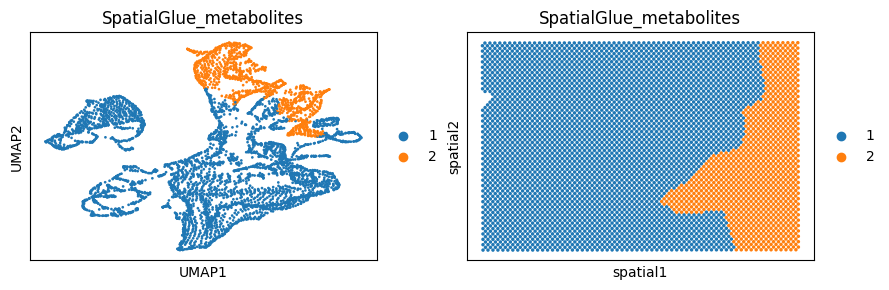

In [34]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='emb_latent_omics2', add_key='SpatialGlue_metabolites', n_clusters=2, method=tool, use_pca=False)
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='emb_latent_omics2', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue_metabolites', ax=ax_list[0], title='SpatialGlue_metabolites', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_metabolites', ax=ax_list[1], title='SpatialGlue_metabolites', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


[<Axes: title={'center': 'SpatialGlue_metabolites'}, xlabel='spatial1', ylabel='spatial2'>]

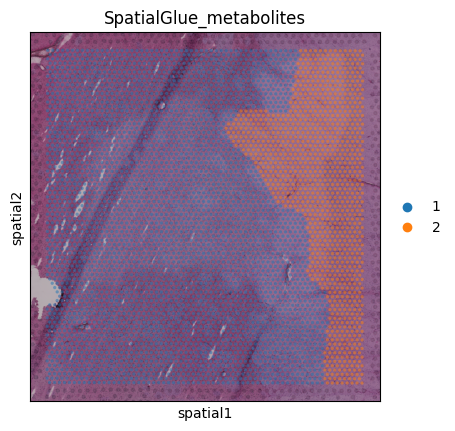

In [35]:
sc.pl.spatial(adata, 
              img_key="hires", 
              color=['SpatialGlue_metabolites'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None, 
              bw=False, 
              alpha_img=1,
              alpha=0.5,
              show=False)

In [29]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=2, method=tool, use_pca=False)

fitting ...
  |======================================================================| 100%


/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

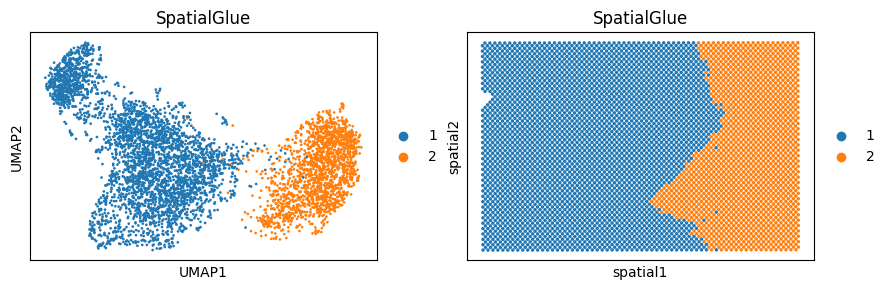

In [30]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(9, 3))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=15, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


[<Axes: title={'center': 'SpatialGlue'}, xlabel='spatial1', ylabel='spatial2'>]

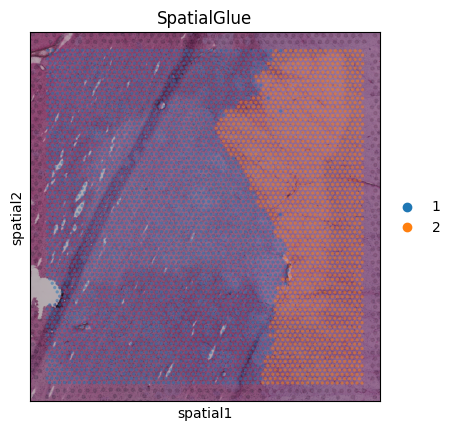

In [32]:
sc.pl.spatial(adata, 
              img_key="hires", 
              color=['SpatialGlue'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None, 
              bw=False, 
              alpha_img=1,
              alpha=0.5,
              show=False)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


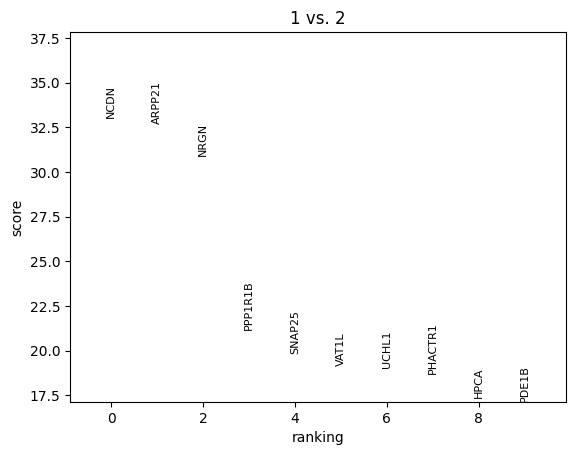

In [36]:
adata.obs['SpatialGlue'] = adata.obs['SpatialGlue'].astype('str')
adata.obs['SpatialGlue'] = adata.obs['SpatialGlue'].astype('category')
sc.tl.rank_genes_groups(adata, "SpatialGlue", groups=["1"], reference="2", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["1"], n_genes=10)

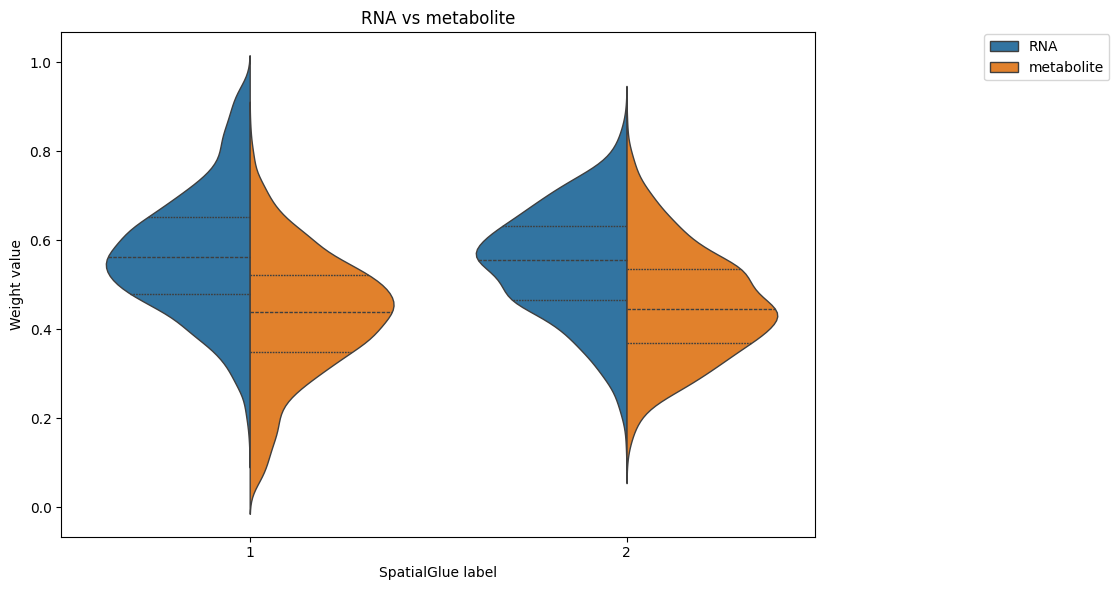

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.rcParams['figure.figsize'] = (12, 6)

# 创建示例数据（假设 adata 是一个 AnnData 对象）
# 这里假设 adata.obsm['alpha'] 和 adata.obs['SpatialGlue'] 已经定义
# 为了演示，使用随机数据代替
import numpy as np

# 创建 DataFrame
df = pd.DataFrame(columns=['RNA', 'metabolite', 'label'])
df['RNA'], df['metabolite'] = adata.obsm['alpha'][:, 0], adata.obsm['alpha'][:, 1]
df['label'] = adata.obs['SpatialGlue'].to_list()

# 重塑数据
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']

# 绘制小提琴图
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                    split=True, inner="quart", linewidth=1)

# 设置标题和标签
ax.set_title('RNA vs metabolite')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

# 调整布局
plt.tight_layout(w_pad=0.05)

# 显示图形
plt.show()